# Fragility Analysis of TVB Simulations

7/9/18: Fragility analysis of different TVB simulations to observe effects of the noise level, conduction speed, and other parameters on fragility metric.

In [1]:
import resource 
resource.setrlimit(resource.RLIMIT_NOFILE, (10000, -1))

import numpy as np
import os
import sys
import mne
import json
import pandas as pd

from scipy.stats import linregress

# import basic plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility
from fragility.io.loaders.dataset.tvbsim import RecordingSim
from fragility.io.loaders.dataset.loadtvbdata import StructuralDataLoader
from fragility.io.loaders.patient.subject import Subject

from fragility.io.loaders.results.mvar import ResultsMVAR
from fragility.io.loaders.results.pert import ResultsPert

import multiprocessing as mp
from fragility.execute.cluster.hpc_mvarmodel import MvarMPModel
from fragility.execute.cluster.hpc_pertmodel import PertMPModel
from fragility.execute.cluster.hpc_merge import MergeCompute

print("Number of CPUs we can use: ", mp.cpu_count())

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')



Number of CPUs we can use:  8


In [2]:
def map_ind_with_gain(gainmat, inds, thresh=0.1):
    # first normalize gain matrix
    gainmat = gainmat / np.max(gainmat)
    gainmat[gainmat < thresh] = 0
    # initialize region mapping from regions -> contacts
    contact_inds = []
    for ind in inds:
        # get current row on result matrix, and find max to gain matrix
        regcontact = np.where(gainmat[:,ind] == np.max(gainmat[:,ind]))[0][0]
        # add to the reg_matrix
        contact_inds.append(regcontact)
    return contact_inds

def map_ez_with_gain(gainmat, thresh=0.1):
    # first normalize gain matrix
    gainmat = gainmat / np.max(gainmat)
    gainmat[gainmat < thresh] = 0
    # initialize region mapping from regions -> contacts
    reg_hash = dict()
    for i in range(gainmat.shape[0]):
        # get current row on result matrix, and find max to gain matrix
        contactreg = np.where(gainmat[i,:] == np.max(gainmat[i,:]))[0][0]
        # add to the reg_matrix
        if contactreg not in reg_hash.keys():
            reg_hash[contactreg] = [i]
        else:
            reg_hash[contactreg].append(i)
    return reg_hash
def map_ez_with_regs(contact_regs):
    # initialize region mapping from regions -> contacts
    reg_hash = dict()
    for icontact in range(len(contact_regs)):
        contactreg = contact_regs[icontact] - 1
        if contactreg not in reg_hash.keys():
            reg_hash[contactreg] = 1
        else:
            reg_hash[contactreg] += 1
    return reg_hash

# Run Fragility Analysis

In [4]:
# load in structural data for this patient
patient = 'id002_cj'
rawdatadir = os.path.join('/Volumes/ADAM LI/rawdata/pipelinedata/_old/', patient)
rawloader = StructuralDataLoader(root_dir=rawdatadir)
print(rawloader)

In [5]:
outputdatadir = os.path.expanduser('~/Downloads/tvbsim_exp/sim_output')

reference = 'monopolar'

rawdatadir = os.path.join(outputdatadir, patient)

In [20]:
recording = RecordingSim(root_dir=rawdatadir, preload=False)
jsonfilepaths = recording.jsonfilepaths

jsonfilepath = jsonfilepaths[2]
recording.load_sim(jsonfilepath)
rawdata = recording.load_all(reference=reference)

# mask data appropriately
recording.mask_meta_data()
rawdata = recording.mask_raw_data(rawdata)
metadata = recording.metadata

print("Loaded ", jsonfilepath)
print(jsonfilepaths)
print(rawdata.shape)
print(metadata.keys())

Creating RawArray with float64 data, n_channels=162, n_times=45000
    Range : 0 ... 44999 =      0.000 ...    44.999 secs
Ready.
Set line frequency as: 50
reference is  monopolar
Loading monopolar data!
Loaded  id002_cj_cond=3_iext=3.1_eps1=0.5_default.json
['id002_cj_cond=3_default.json', 'id002_cj_cond=3_iext=3.1_eps1=-0.5_default.json', 'id002_cj_cond=3_iext=3.1_eps1=0.5_default.json', 'id002_cj_cond=3_iext=3.1_eps1=-0.25_default.json', 'id002_cj_cond=3_iext=3.5_eps1=0.5_default.json', 'id002_cj_cond=3_iext=3.1_eps1=0.25_default.json']
(162, 45000)
dict_keys(['chanlabels', 'chanxyz', 'clinez', 'clinpz', 'condspeed', 'ezindices', 'ezregs', 'gainmat', 'goodchaninds', 'offsettimes', 'onsettimes', 'patient', 'pzindices', 'pzregs', 'regions', 'regions_centers', 'samplerate', 'shuffledpat', 'simfilename', 'x0ez', 'x0norm', 'x0pz', 'lowpass_freq', 'highpass_freq', 'meas_date', 'linefreq', 'onsetsec', 'offsetsec', 'onsetind', 'offsetind', 'rawfilename', 'reference', 'type', 'bad_channels',

In [21]:
numcores = 4
mvar_tempdir = os.path.join('/Users/adam2392/Downloads/temp/mvar/', jsonfilepath)
mvar_outputdir = os.path.join('/Users/adam2392/Downloads/temp', patient)
if not os.path.exists(mvar_tempdir):
    os.makedirs(mvar_tempdir)
if not os.path.exists(mvar_outputdir):
    os.makedirs(mvar_outputdir)
    
# parameters
winsize = 250
stepsize = 125
samplerate = metadata['samplerate']

mvar_outputmetafilename = metadata['rawfilename'].split('.npz')[0]+'_mvar.json'
mvar_outputfilename = mvar_outputmetafilename.split('.json')[0] + 'model.npz'
mvar_outputfilename = os.path.join(mvar_outputdir, mvar_outputfilename)
mvar_outputmetafilename = os.path.join(mvar_outputdir, mvar_outputmetafilename)
print(mvar_outputmetafilename)
print(mvar_outputfilename)

pert_tempdir = mvar_tempdir.replace('mvar', 'pert')
pert_outputdir = os.path.join('/Users/adam2392/Downloads/temp', patient)
if not os.path.exists(pert_tempdir):
    os.makedirs(pert_tempdir)
if not os.path.exists(pert_outputdir):
    os.makedirs(pert_outputdir)
    
# parameters
radius = 1.5
perturbtype = 'C'

pert_outputmetafilename = mvar_outputmetafilename.replace('mvar', 'pert')
pert_outputfilename = mvar_outputfilename.replace('mvarmodel', 'pertmodel')

pert_outputfilename = os.path.join(pert_outputdir, pert_outputfilename)
pert_outputmetafilename = os.path.join(pert_outputdir, pert_outputmetafilename)
print(pert_outputmetafilename)
print(pert_outputfilename)
idatafile=0

/Users/adam2392/Downloads/temp/id002_cj/id002_cj_cond=3_iext=3.1_eps1=0.5_default_mvar.json
/Users/adam2392/Downloads/temp/id002_cj/id002_cj_cond=3_iext=3.1_eps1=0.5_default_mvarmodel.npz
/Users/adam2392/Downloads/temp/id002_cj/id002_cj_cond=3_iext=3.1_eps1=0.5_default_pert.json
/Users/adam2392/Downloads/temp/id002_cj/id002_cj_cond=3_iext=3.1_eps1=0.5_default_pertmodel.npz


In [22]:
with open('/Users/adam2392/Downloads/tngpipeline/clincontacts.json', mode='r') as f:
    clincontacts = json.load(f)
print(clincontacts.keys())
print(metadata.keys())
chanlabels = metadata['chanlabels']
gainmat = metadata['gainmat']
contact_regs = metadata['contact_regs']
if patient in clincontacts.keys():
    clinezelecs = clincontacts[patient]
else:
    clinregez = metadata['clinez'] #metadata['regezinds']
    clinregezinds = rawloader.regezinds
    clinezinds = map_ind_with_gain(gainmat, clinregezinds, thresh=0.1)
    clinezelecs = chanlabels[clinezinds]
#     clinregezinds = [ind for ind, reg in enumerate(metadata['regions']) if reg in clinregez]

print(recording.regezinds)
print(clinezinds)
print(clinezelecs)
# print(len(chanlabels))
# print(len(clinezelecs))

dict_keys(['id001_bt', 'id002_sd', 'id003_mg', 'id004_bj', 'id005_ft', 'id006_mr', 'id007_rd', 'id008_dmc', 'id009_ba', 'id010_cmn', 'id011_gr', 'id013_lk', 'id014_vc', 'id015_gjl', 'id016_lm', 'id017_mk', 'id018_lo', 'id020_lma', 'id021_jc', 'id022_te', 'id023_br'])
dict_keys(['chanlabels', 'chanxyz', 'clinez', 'clinpz', 'condspeed', 'ezindices', 'ezregs', 'gainmat', 'goodchaninds', 'offsettimes', 'onsettimes', 'patient', 'pzindices', 'pzregs', 'regions', 'regions_centers', 'samplerate', 'shuffledpat', 'simfilename', 'x0ez', 'x0norm', 'x0pz', 'lowpass_freq', 'highpass_freq', 'meas_date', 'linefreq', 'onsetsec', 'offsetsec', 'onsetind', 'offsetind', 'rawfilename', 'reference', 'type', 'bad_channels', 'non_eeg_channels', 'chanxyzlabels', 'contact_regs', 'regezinds', 'atlas', 'clinezelecs', 'clinresectelecs'])
None
[88, 68, 87]
["pp'5" "gl'12" "pp'4"]


In [23]:
# run mvar analysis
runcompute = MvarMPModel(patient, winsize, stepsize, samplerate, 
                             reference, numcores, mvar_tempdir, 
                             mvar_outputmetafilename, mvar_outputfilename)
runcompute.loaddata(rawdata)
runcompute.loadmetadata(metadata)
numwins = runcompute.numwins

print(runcompute.winsize)
print(runcompute.samplerate)
print(numwins)
print(mvar_tempdir)
print(runcompute.tempdir)

250
1000
359
/Users/adam2392/Downloads/temp/mvar/id002_cj_cond=3_iext=3.1_eps1=0.5_default.json
/Users/adam2392/Downloads/temp/mvar/id002_cj_cond=3_iext=3.1_eps1=0.5_default.json


In [24]:
runcompute.run_all()

created temporary directory /Users/adam2392/Downloads/temp/mvar/id002_cj_cond=3_iext=3.1_eps1=0.5_default.jsonabout to run pool!Finished mvar model computation for 359 windows.Saved metadata as json!  dict_keys(['chanlabels', 'chanxyz', 'clinez', 'clinpz', 'condspeed', 'ezindices', 'ezregs', 'gainmat', 'goodchaninds', 'offsettimes', 'onsettimes', 'patient', 'pzindices', 'pzregs', 'regions', 'regions_centers', 'samplerate', 'shuffledpat', 'simfilename', 'x0ez', 'x0norm', 'x0pz', 'lowpass_freq', 'highpass_freq', 'meas_date', 'linefreq', 'onsetsec', 'offsetsec', 'onsetind', 'offsetind', 'rawfilename', 'reference', 'type', 'bad_channels', 'non_eeg_channels', 'chanxyzlabels', 'contact_regs', 'regezinds', 'atlas', 'clinezelecs', 'clinresectelecs', 'winsize', 'stepsize', 'timepoints', 'onsetwin', 'offsetwin', 'mvarfilename'])


In [25]:
print(metadata.keys())
print(samplerate)
print(metadata['onsetsec'])

merger = MergeCompute(mvar_tempdir, numwins)
merger.loadmetafile(mvar_outputmetafilename)
merger.mergemvardata(mvar_outputfilename)
merger.metadata['mvarfilename'] = os.path.basename(mvar_outputfilename)
merger._writejsonfile(merger.metadata, mvar_outputmetafilename)

dict_keys(['chanlabels', 'chanxyz', 'clinez', 'clinpz', 'condspeed', 'ezindices', 'ezregs', 'gainmat', 'goodchaninds', 'offsettimes', 'onsettimes', 'patient', 'pzindices', 'pzregs', 'regions', 'regions_centers', 'samplerate', 'shuffledpat', 'simfilename', 'x0ez', 'x0norm', 'x0pz', 'lowpass_freq', 'highpass_freq', 'meas_date', 'linefreq', 'onsetsec', 'offsetsec', 'onsetind', 'offsetind', 'rawfilename', 'reference', 'type', 'bad_channels', 'non_eeg_channels', 'chanxyzlabels', 'contact_regs', 'regezinds', 'atlas', 'clinezelecs', 'clinresectelecs', 'winsize', 'stepsize', 'timepoints', 'onsetwin', 'offsetwin', 'mvarfilename'])
1000
None


In [26]:
datastruct = np.load(os.path.join(mvar_outputfilename))
adjmats = datastruct['adjmats']

with open(os.path.join(mvar_outputmetafilename), encoding="utf8") as f:
    metadata = json.load(f)
print(metadata.keys())

dict_keys(['atlas', 'bad_channels', 'chanlabels', 'chanxyz', 'chanxyzlabels', 'clinez', 'clinezelecs', 'clinpz', 'clinresectelecs', 'condspeed', 'contact_regs', 'ezindices', 'ezregs', 'gainmat', 'goodchaninds', 'highpass_freq', 'linefreq', 'lowpass_freq', 'meas_date', 'mvarfilename', 'non_eeg_channels', 'offsetind', 'offsetsec', 'offsettimes', 'offsetwin', 'onsetind', 'onsetsec', 'onsettimes', 'onsetwin', 'patient', 'pzindices', 'pzregs', 'rawfilename', 'reference', 'regezinds', 'regions', 'regions_centers', 'samplerate', 'shuffledpat', 'simfilename', 'stepsize', 'timepoints', 'type', 'winsize', 'x0ez', 'x0norm', 'x0pz'])


In [27]:
# run perturbation analysis
runcompute = PertMPModel(patient, radius, perturbtype, numcores, 
                             pert_tempdir, pert_outputmetafilename, pert_outputfilename)
runcompute.loaddata(adjmats)
runcompute.loadmetadata(metadata)
numwins = runcompute.numwins
print(numwins)
print(runcompute.tempdir)

359
/Users/adam2392/Downloads/temp/pert/id002_cj_cond=3_iext=3.1_eps1=0.5_default.json


In [28]:
runcompute.run_all()

created temporary directory /Users/adam2392/Downloads/temp/pert/id002_cj_cond=3_iext=3.1_eps1=0.5_default.jsonabout to run pool!
Finished pert model computation for 359 windows.

In [29]:
print(pert_tempdir)
merger = MergeCompute(pert_tempdir, numwins)
merger.loadmetafile(pert_outputmetafilename)
merger.mergepertdata(pert_outputfilename)
merger.metadata['pertfilename'] = os.path.basename(pert_outputfilename)
merger._writejsonfile(merger.metadata, pert_outputmetafilename)

/Users/adam2392/Downloads/temp/pert/id002_cj_cond=3_iext=3.1_eps1=0.5_default.json


# Do Visualization

In [35]:
pertloader = ResultsPert(pert_outputdir, patient=patient)

print(pert_outputdir)
print(pertloader.jsonfilepaths)

/Users/adam2392/Downloads/temp/id002_cj
['id002_cj_cond=3_default_mvar.json', 'id002_cj_cond=3_default_pert.json', 'id002_cj_cond=3_iext=3.1_eps1=0.5_default_mvar.json', 'id002_cj_cond=3_iext=3.1_eps1=0.5_default_pert.json', 'id002_cj_cond=3_iext=3.1_eps1=-0.5_default_mvar.json', 'id002_cj_cond=3_iext=3.1_eps1=-0.5_default_pert.json']


Loading pert data from:  /Users/adam2392/Downloads/temp/id002_cj/id002_cj_cond=3_default_pertmodel.npz
Can't access goodchan_labels


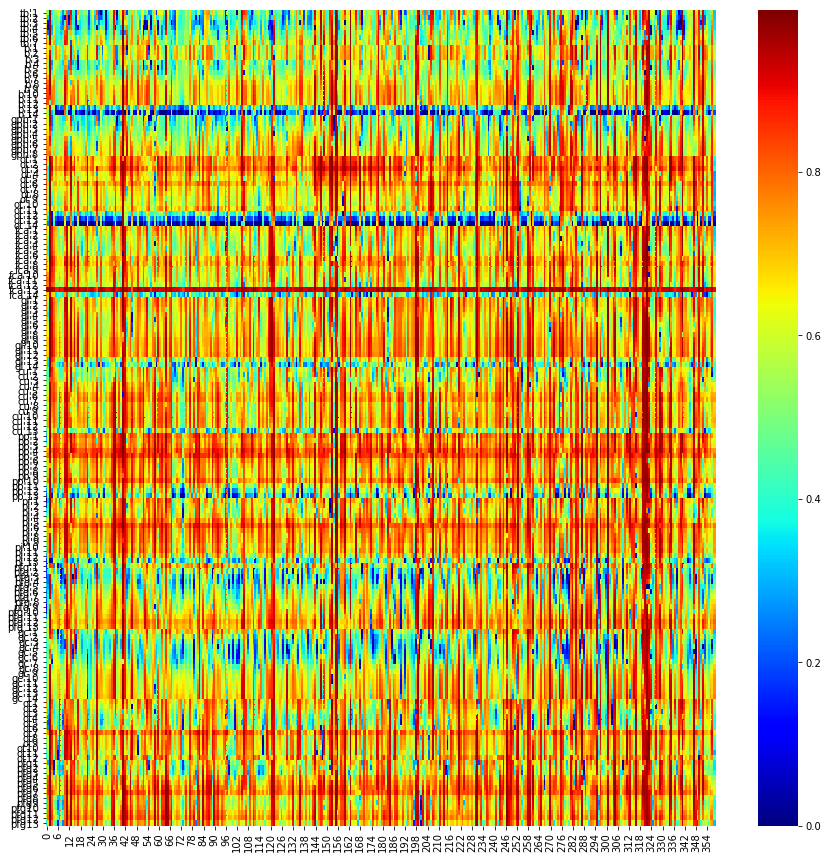

In [40]:
pertjsonfilepath = pertloader.jsonfilepaths[0]
pertloader.loadpipeline(pertjsonfilepath)

# extract data
pertmetadata = pertloader.metadata
pertmats = pertloader.pertmat
fragmat = pertloader.fragmat
metadata = pertloader.metadata
szonset = metadata['onsetwin']
szoffset = metadata['offsetwin']
timepoints = np.array(metadata['timepoints'])
chanlabels = np.array(metadata['chanlabels'])
plt.figure(figsize=(15,15))
sns.heatmap(fragmat, cmap='jet', yticklabels=chanlabels)
